In [ ]:
from src.values import *
from src.utils import *
import matplotlib.pyplot as plt 
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky

In [7]:
N_t = np.floor(25/ a_t).astype(np.int64)
N_z = len(z_values) 
print(f'number of grid in x :{N_t}, z:{N_z}, total:{N_t**2*N_z}')


number of grid in x :65, z:295, total:1246375


In [8]:
x = np.arange(N_t)* a_t 
y = np.arange(N_t)* a_t 
X, Y = np.meshgrid(x, y)
V_0000 = np.zeros((N_t, N_t, N_z))
V_1000 = np.zeros((N_t, N_t, N_z))


In [9]:
points = np.column_stack([X.ravel(), Y.ravel()]) # linearlized points 

exp_cov = cdist(points, points, 'sqeuclidean')
exp_cov = np.exp(-exp_cov/4/l_t**2)
x_diffs = np.subtract.outer(points[:,0], points[:, 0])/2/l_t
x_diffs[x_diffs>1]=0
x_diffs[x_diffs<-1]=0



c1 = lambda z: (E_G*a_t)**2 * n(z)*(1-n(z))/(4*np.pi*l_t**2)* exp_cov
c2 = lambda z: (E_G*a_t)**2 * n(z)*(1-n(z))/(4*np.pi*l_t**2)* exp_cov /2* (1 - x_diffs**2)
c12 = lambda z: (E_G*a_t)**2 * n(z)*(1-n(z))/(4*np.pi*l_t**2)* exp_cov * (-x_diffs)

c_joint = lambda z: np.block([[c1(z), c12(z)], [c12(z).T, c2(z)]])



In [ ]:
for i,z in enumerate(z_values):
    C_joint = c_joint(z)
    mean = np.zeros(C_joint.shape[0])  # Zero mean
    # print(i)
    # eigvals = np.linalg.eigvalsh(C_joint)
    # print("Min Eigenvalue:", np.min(eigvals))
    # L = cholesky(C_joint + 1e-3 * np.eye(C_joint.shape[0]), lower=True)  # Cholesky decomposition    
    # random_samples = L @ np.random.randn(C_joint.shape[0])
    
    random_samples = np.random.multivariate_normal(mean =mean, cov = C_joint)
    V_0000[:, :, i]+= random_samples[:N_t**2].reshape(N_t, N_t)
    V_1000[:, :, i]+= random_samples[N_t**2:].reshape(N_t, N_t)


c:\Users\Minyoung Kim\anaconda3\envs\TBDSi\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:

well_potential = V_l()
electric_potential_ = electric_potential()

Delta_map = np.zeros((N_t, N_t, 4))
Rabi_vals = np.zeros((N_t, N_t, 2)) 

for i, x0 in enumerate(x): 
    for j, y0 in enumerate(y): 

        gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000[i, j, :], electric_noise=0, electric_potential=electric_potential_)
        
        Delta_0000 = expectation_value((well_potential+ V_0000[i, j, :]) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        Delta_1000 = expectation_value((well_potential+ V_1000[i, j, :]) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        
        Delta_map[i, j, 0]+= Delta_0000[0]
        Delta_map[i, j, 1]+= Delta_0000[1]
        
        Delta_map[i, j, 2]+= Delta_1000[0]
        Delta_map[i, j, 3]+= Delta_1000[1]
        
        
        beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
        
        Omega_0 =calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple')/10**9/B #GHz/T 
        Omega_dipole=calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple_dipole')/10**9/B #GHz/T
        Rabi_vals[i, j, 0]+= Omega_0
        Rabi_vals[i, j, 1]+=Omega_dipole

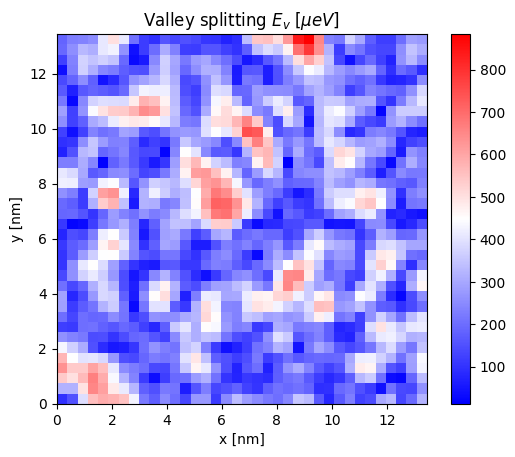

In [ ]:
plt.imshow(2*Delta_map[:, :, 0]*10**3, cmap="bwr", origin="lower", extent=[0, x.max(), 0, y.max()])
plt.colorbar()  # Add colorbar

y_points, x_points = np.where(Delta_map[: ,:, 0] <10**(-3)) 
plt.scatter(x_points*a_t, y_points*a_t, color="green", marker="*", s=100)

plt.title('Valley splitting '+r'$E_v\;[\mu eV]$')
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.show()

In [63]:
cut = 80 # to save memory 
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMMSS

well_potential = V_l()
electric_potential_ = electric_potential()

Delta_map = np.zeros((N_t-2*cut, N_t-2*cut, 4))
Rabi_vals = np.zeros((N_t-2*cut, N_t-2*cut, 2)) 

for i, x0 in enumerate(x[cut:-cut]): 
    for j, y0 in enumerate(y[cut:-cut]): 
        
        X, Y = np.meshgrid(x[i: i+2*cut], y[j: j+2*cut])
        
        V_0000 = np.sum(potential_disorder[i:i+2*cut, j:j+2*cut, :]*(chi_0000(X, Y, x0, y0).reshape(2*cut, 2*cut, 1) @ np.ones((1,N_z))), axis = (0, 1))
        V_1000 = np.sum(potential_disorder[i:i+2*cut, j:j+2*cut, :]*(chi_1000(X, Y, x0, y0).reshape(2*cut, 2*cut, 1) @ np.ones((1,N_z))), axis = (0, 1))
        
        gs = get_groundstate(z_values, well_potential=well_potential, disorder=V_0000, electric_noise=0, electric_potential=electric_potential_)
        
        Delta_0000 = expectation_value((well_potential+ V_0000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        Delta_1000 = expectation_value((well_potential+ V_1000) *np.exp((0-1j)*2*k_0*z_values), ground_state=gs)
        
        Delta_map[i, j, 0]+= Delta_0000[0]
        Delta_map[i, j, 1]+= Delta_0000[1]
        
        Delta_map[i, j, 2]+= Delta_1000[0]
        Delta_map[i, j, 3]+= Delta_1000[1]
        
        
        beta =expectation_value(beta_0*np.exp((0+1j)*2*k_1*z_values), ground_state=gs)
        
        Omega_0 =calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple')/10**9/B #GHz/T 
        Omega_dipole=calculate_Rabi_freq(Delta_0000, Delta_1000, beta, mode='simple_dipole')/10**9/B #GHz/T
        Rabi_vals[i, j, 0]+= Omega_0
        Rabi_vals[i, j, 1]+=Omega_dipole
        
np.save(f"./Results/{timestamp}_3D_Rabi", Rabi_vals) 
np.save(f"./Results/{timestamp}_3D_Delta", Delta_map) 


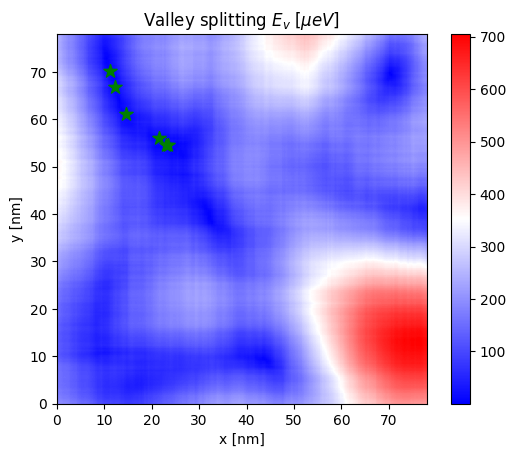

In [92]:
plt.imshow(2*Delta_map[:, :, 0]*10**3, cmap="bwr", origin="lower", extent=[0, x.max()-2*cut *a_t, 0, y.max()-2*cut*a_t])
plt.colorbar()  # Add colorbar

y_points, x_points = np.where(Delta_map[: ,:, 0] <10**(-3)) 
plt.scatter(x_points*a_t, y_points*a_t, color="green", marker="*", s=100)

plt.title('Valley splitting '+r'$E_v\;[\mu eV]$')
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.show()

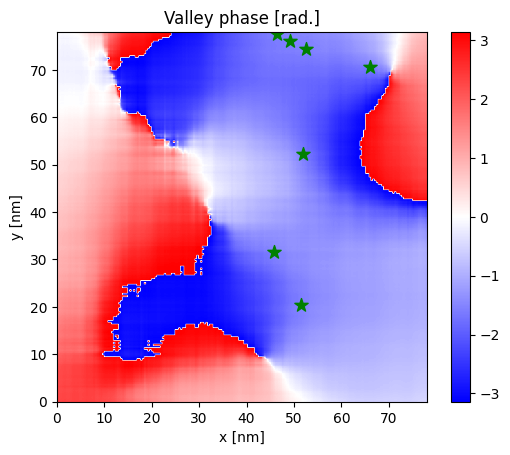

In [91]:
plt.imshow(Delta_map[:, :, 1], cmap="bwr", origin="lower", extent=[0, x.max()-2*cut *a_t, 0, y.max()-2*cut*a_t])
plt.colorbar()  # Add colorbar

y_points, x_points = np.where(np.abs((np.abs(Delta_map[: ,:, 1])- np.pi/2))<10**(-4)) 
plt.scatter(x_points*a_t, y_points*a_t, color="green", marker="*", s=100)

plt.title('Valley phase [rad.]')#+r'$E_v\;[\mu eV]$')
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.show()

In [66]:
np.mean(2*Delta_map[:, :, 0]*10**3)

199.38962996547343

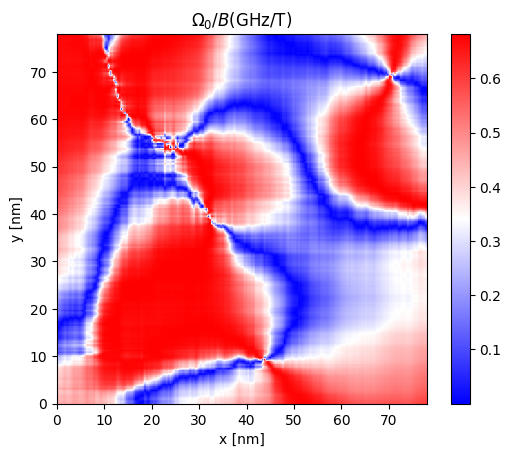

In [67]:
plt.imshow(np.abs(Rabi_vals[:, :, 0]), cmap="bwr", origin="lower", extent=[0, x.max()-2*cut *a_t, 0, y.max()-2*cut*a_t])
plt.colorbar()  # Add colorbar
plt.title(r'$\Omega_0/B$'+'(GHz/T)')
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.show()

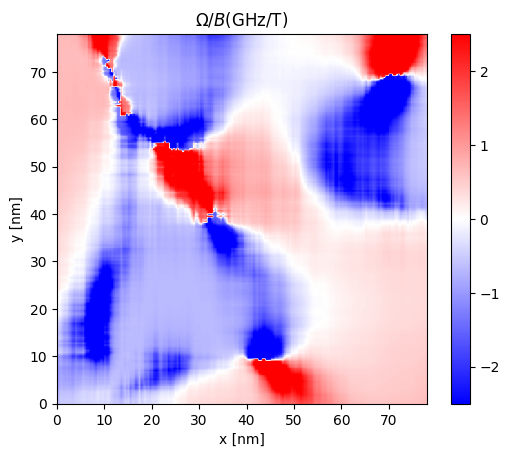

In [90]:
Omega = -Rabi_vals[:, :, 1] + 2 * Rabi_vals[:, :, 0]

Omega[Omega>2.5]=2.5
Omega[Omega<-2.5]=-2.5
plt.imshow(Omega, cmap="bwr", origin="lower", extent=[0, x.max()-2*cut *a_t, 0, y.max()-2*cut*a_t])

plt.colorbar()  # Add colorbar
plt.title(r'$\Omega/B$'+'(GHz/T)')
plt.xlabel("x [nm]")
plt.ylabel("y [nm]")
plt.show()